In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')
import tensorflow as tf
from tqdm import trange

from deepx import T
from deepx.nn import Relu
from deepx.stats import Gaussian, Dirichlet, NIW, Categorical, kl_divergence
from activations import Gaussian as GaussianLayer

In [57]:
seed = 2
K = 2
N = 1000
D = 2
L = 2

a = 100.
s0 = 50.
s = 1.

In [58]:
def generate_data(N, D, K, sigma0=10, sigma=1, seed=None, alpha=100):
    pi = np.random.dirichlet([a] * K)
    X = np.zeros((N, D))
    mu, sigma = np.random.multivariate_normal(mean=np.zeros(D), cov=np.eye(D) * sigma0, size=[K]), np.tile(np.eye(D)[None] * sigma, [K, 1, 1])
    for i in range(N):
        z = np.random.choice(K, p=pi)
        X[i] = np.random.multivariate_normal(mean=mu[z], cov=sigma[z])
    return X.astype(np.float32)

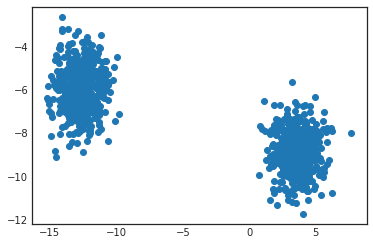

In [59]:
np.random.seed(seed)
X = generate_data(N, D, K, sigma0=s0, sigma=s)
plt.scatter(*X.T)
plt.show()

# Prior description

In [61]:
p_pi = Dirichlet(T.constant([a] * K))
p_theta = NIW(list(map(lambda x: T.constant(np.array(x).astype(T.floatx())), [np.eye(D) * sigma, np.zeros(D), 1, D + 1])))

# Global variational distributions

In [62]:
def make_variable(dist):
    return dist.__class__(T.variable(dist.get_parameters('natural')), parameter_type='natural')
q_pi = make_variable(Dirichlet(np.ones([K], dtype=T.floatx())))
q_theta = make_variable(NIW(map(lambda x: np.array(x).astype(T.floatx()), [np.tile(np.eye(D)[None] * 100, [K, 1, 1]), np.random.multivariate_normal(mean=np.zeros([D]), cov=np.eye(D) * 20, size=[K]), np.ones(K), np.ones(K) * (D + 1)])))

sigma, mu = Gaussian(q_theta.expected_sufficient_statistics(), parameter_type='natural').get_parameters('regular')
alpha = Categorical(q_pi.expected_sufficient_statistics(), parameter_type='natural').get_parameters('regular')

# Neural networks

In [63]:
with T.initialization('xavier'):
    obs_net = lambda y: Gaussian([T.eye(D, batch_shape=T.shape(y)[:-1]), y])#Relu(L, 20) >> Relu(20) >> GaussianLayer(D)
    rec_net = Relu(D, 20) >> Relu(20) >> GaussianLayer(L)
rec_net.initialize()

# Setting up variables

In [64]:
y = T.matrix()
batch_size = T.shape(y)[0]
y_out = rec_net(y)
num_batches = N / T.to_float(batch_size)

# Indirect amortization

In [65]:
def indirect_meanfield(local_kl, tol=1e-7, max_iter=1000):
    z_stats = Categorical(Dirichlet([10.0] * K).sample(batch_size)).expected_sufficient_statistics()
    
    y_stats = y_out.get_parameters('natural')
    theta_stats = q_theta.expected_sufficient_statistics()
    i = T.constant(0)

    def meanfield_condition(i, _, curr_kl, prev_kl):
        return T.logical_and(i < max_iter, T.abs(curr_kl - prev_kl) > tol)
    
    def meanfield_loop(i, z_stats, curr_kl, prev_kl):
        expected_x = T.einsum('ik,kab->iab', z_stats, theta_stats)
        next_x = y_stats + expected_x
        p_x = Gaussian(expected_x, parameter_type='natural')
        q_x = Gaussian(next_x, parameter_type='natural')
        kl = T.sum(kl_divergence(q_x, p_x))
        
        expected_z = T.einsum('iab,jab->ij', q_x.expected_sufficient_statistics(), theta_stats)
        parent_z = p_pi.expected_sufficient_statistics()[None]
        q_z = Categorical(expected_z - T.logsumexp(expected_z, -1)[..., None], parameter_type='natural')
        p_z = Categorical(parent_z - T.logsumexp(parent_z, -1), parameter_type='natural')
        kl += T.sum(kl_divergence(q_z, p_z))
        return i + 1, q_z.expected_sufficient_statistics(), kl, curr_kl
        
    _, z_stats, _, _ = T.while_loop(
        meanfield_condition,
        meanfield_loop,
        [i, z_stats, T.to_float(float('inf')), T.constant(0.0)],
    )
   
    q_z = Categorical(z_stats, parameter_type='natural')
    
    expected_x = T.einsum('ik,kab->iab', z_stats, theta_stats)
    next_x = y_stats + expected_x
    q_x = Gaussian(next_x, parameter_type='natural')
    
    return q_x, q_z, local_kl(q_x, q_z)

# Direct amortization

In [66]:
def direct_meanfield(local_kl):

    y_stats = y_out.get_parameters('natural')
    theta_stats = q_theta.expected_sufficient_statistics()
    
    next_x = y_stats
    q_x = Gaussian(next_x, parameter_type='natural')
    
    expected_z = T.einsum('iab,jab->ij', q_x.expected_sufficient_statistics(), theta_stats)
    parent_z = p_pi.expected_sufficient_statistics()[None]
    q_z = Categorical(expected_z - T.logsumexp(expected_z, -1)[..., None], parameter_type='natural')
    return q_x, q_z, local_kl(q_x, q_z)

# Normal gradients

In [67]:
def normal_kl(q_x, q_z):
    theta_stats = q_theta.expected_sufficient_statistics()
    z_stats = q_z.expected_sufficient_statistics()
    p_x = Gaussian(T.einsum('ik,kab->iab', z_stats, theta_stats), parameter_type='natural')
    kl = T.sum(kl_divergence(q_x, p_x))
    expected_z = T.einsum('iab,jab->ij', q_x.expected_sufficient_statistics(), theta_stats)
    parent_z = p_pi.expected_sufficient_statistics()[None]
    p_z = Categorical(parent_z - T.logsumexp(parent_z, -1), parameter_type='natural')
    kl += T.sum(kl_divergence(q_z, p_z))
    return kl

def svae(inference_type, kl_type):
    kl = normal_kl if kl_type == 'normal' else blah
    q_x, q_z, local_kl = direct_meanfield(kl) if inference_type == 'direct' else indirect_meanfield(kl)
    global_kl = T.sum(kl_divergence(q_theta, p_theta) + kl_divergence(q_pi, p_pi))
    x_samples = q_x.sample()[:, 0]
    p_y = obs_net(x_samples)
    num_datapoints = T.to_float(N)
    ll = T.sum(p_y.log_likelihood(y))
    elbo = (num_batches * (ll - local_kl)
               - global_kl
            ) / num_datapoints
    return q_x, q_z, elbo

def natural_gradient(q_x, q_z, nat_scale=1.0):
    x_message = Gaussian.unpack(q_x.expected_sufficient_statistics())
    x_stats = NIW.pack([
        x_message[0],
        x_message[1],
        T.ones([batch_size]),
        T.ones([batch_size]),
    ])
    z_stats = q_z.expected_sufficient_statistics()
    
    theta_stats = T.einsum('ia,ibc->abc', z_stats, x_stats)
    parent_theta = p_theta.get_parameters('natural')[None]
    current_theta = q_theta.get_parameters('natural')
    theta_gradient = nat_scale / N * (parent_theta + num_batches * theta_stats - current_theta)
    
    pi_stats = T.sum(z_stats, 0)
    parent_pi = p_pi.get_parameters('natural')
    current_pi = p_pi.get_parameters('natural')
    pi_gradient = nat_scale / N * (parent_pi + num_batches * pi_stats - current_pi)
    return theta_gradient, pi_gradient

def get_op(svae):
    q_x, q_z, elbo = svae()
    natgrads = zip(natural_gradient(q_x, q_z), [q_theta.get_parameters('natural'), q_pi.get_parameters('natural')])
    nat_op = tf.train.MomentumOptimizer(1e-1, 0.1).apply_gradients([(-a, b) for a, b in natgrads])
    grad_op = tf.train.AdamOptimizer(1e-3).minimize(-elbo, var_list=rec_net.get_parameters())
    return tf.group(grad_op, nat_op), {'elbo': elbo }
    
def train(sess, train_op, info, num_iters=1, batch_size=20):
    elbos = []
    for i in trange(num_iters):
        batch_idx = np.random.permutation(N)[:batch_size]
        _, e = sess.run([train_op, info['elbo']], {y:X[batch_idx]})
        elbos.append(e)
    return elbos

# Helper functions

In [68]:
def plot_ellipse(alpha, mean, cov, line=None):
    t = np.linspace(0, 2*np.pi, 100) % (2*np.pi)
    circle = np.vstack((np.sin(t), np.cos(t)))
    ellipse = 2.*np.dot(np.linalg.cholesky(cov), circle) + mean[:,None]
    if line:
        line.set_data(ellipse)
        line.set_alpha(alpha)
    else:
        plt.plot(ellipse[0], ellipse[1], linestyle='-', linewidth=2)
        
def draw(sess):
    mean, cov, a = sess.run([mu, sigma, alpha])
    plt.scatter(*X.T, s=1)
    for k in range(K):
        plot_ellipse(a[k], mean[k], cov[k])

In [69]:
op, info = get_op(lambda: svae('direct', 'normal'))

In [70]:
sess = T.interactive_session()
elbos = []

In [ ]:
elbos.extend(train(sess, op, info, 1000, batch_size=20))
draw(sess)
plt.figure()
plt.plot(elbos)
plt.show()

 23%|██▎       | 228/1000 [00:00<00:01, 530.84it/s]

1.0